In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

## Create Dataset

In [2]:
MAX_LEN = 100

def generate_sentence(min_len=0, max_len=20, pos=True):
    if pos:
        n = np.random.randint(np.ceil(min_len / 3), np.ceil((max_len) / 3))
        sentence = n*"a" + n*"b" + n*"c"
        return sentence, len(sentence)
    else:
        n_0 = np.random.randint(0, max_len)
        n_1 = np.random.randint(0, max_len - n_0 + 1)
        n_2 = np.random.randint(min_len - n_0 - n_1, max_len - n_0 - n_1 + 1)
        sentence = n_0 * "a" + n_1 * "b" + n_2 * "c"
        return sentence, len(sentence)

def create_data(size=10000, balance=0.1, min_len=0, max_len=20, train=True):
    data = []
    sentence_lengths = []

    for i in range(int(size*balance)):
        sentence, sentence_length = generate_sentence(min_len=min_len, max_len=max_len, pos=True)
        while sentence == "aabbcc" and train:
            sentence, sentence_length = generate_sentence(min_len=min_len, max_len=max_len, pos=True)
        if not train:
            sentence, sentence_length = "aabbcc", 6
        data.append((sentence, 1))
        sentence_lengths.append(sentence_length)
    for i in range(int((size - (size*balance)))):
        sentence, sentence_length = generate_sentence(min_len=min_len, max_len=max_len, pos=False)
        data.append((sentence, 0))
        sentence_lengths.append(sentence_length)
    
    random.shuffle(data)
    average_length = sum(sentence_lengths) / len(sentence_lengths)
    return data, average_length

train_data, avg_sent_length_train = create_data(size=1000, balance=0.2, min_len=0, max_len=20, train=True)
val_data, avg_sent_length_val = create_data(size=1000, balance=0.2, min_len=0, max_len=20, train=False)
test_data, avg_sent_length_test = create_data(size=1000, balance=0.2, min_len=21, max_len=MAX_LEN, train=True)

print(f"Train Data Sample:\n{train_data}")
print(f"Average Sentence Length:\n{avg_sent_length_train}")
print(f"Val Data Sample:\n{val_data}")
print(f"Average Sentence Length:\n{avg_sent_length_val}")
print(f"Test Data Sample:\n{test_data}")
print(f"Average Sentence Length:\n{avg_sent_length_test}")


Train Data Sample:
[('aaaaaaaaaaaaa', 0), ('aaaaaaaaaaaaaaaaaaab', 0), ('aaaaaaaaabbbbbbb', 0), ('aaaabbbbbbbb', 0), ('aaaaaaaaaaaaaaaabbbb', 0), ('aaaaaaaaaaaaaaaaaaa', 0), ('bbbbbbbbbbbbbb', 0), ('aaaaaaaaaaaaaaabbb', 0), ('aaaaaaaaaaaaaaaaaac', 0), ('aaabbbccccc', 0), ('aaaaaaaaaaaaaaaa', 0), ('aaaaaaaaaaaaaabbbb', 0), ('aaaaaaaaaabbbccc', 0), ('abbbbbbbbbbbbbb', 0), ('aaaaabbbbbcccccc', 0), ('aaaaabbbbbbbbbbbbbb', 0), ('aaaabbbb', 0), ('aaabbbccc', 1), ('aaaaaaaaaaabbbbbbc', 0), ('aaaabbbbcccc', 1), ('aaaabbbbcccc', 1), ('bbbbbbccccccccc', 0), ('aaaaaaaaabccccc', 0), ('aaaaabbbbbccccc', 1), ('aaaaaaaaaaaabbbbbbbb', 0), ('aaaaaaaabbbbbbbbbbb', 0), ('aaaaaaaaabbbbbb', 0), ('abbbbbbbbbbbbbbbbbb', 0), ('bbbcccccccccc', 0), ('aaaaaaaaaabbbbbbb', 0), ('aaaaaaaaaaaaaaab', 0), ('aaabbbccc', 1), ('aaaaaaaaaaaaaaaaabbb', 0), ('', 1), ('aaaaaaaaaab', 0), ('aaaabbbbbbbbbbcc', 0), ('aaaaaaaaaaaaaaaaaab', 0), ('aaaaabbbbbccccc', 1), ('aaaaaaaaaaaaaaaaaabb', 0), ('aaaabbbbcccc', 1), ('aaaaaaaaaaa

In [3]:
# Dependencies
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


In [4]:
# Encoding data
class TextDataset(Dataset):
    
    def __init__(self, data):
        self.sentence = [d[0] for d in data]
        self.label = [d[1] for d in data]
        
        self.char_to_index = {'a':1, 'b':2, 'c':3}

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        sentence = self.sentence[idx]
        label = self.label[idx]
        
        sentence_encoded = [self.char_to_index[char] for char in sentence]
        
        return torch.tensor(sentence_encoded, dtype=torch.int64), torch.tensor(label)
    
train_dataset = TextDataset(train_data)

def collate_fn(data):
    sentences, labels = zip(*data)
    sentences = nn.utils.rnn.pad_sequence(sentences, batch_first=True, padding_value=0)
    labels = torch.stack(labels)
    
    return sentences, labels

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

In [5]:
train_loader = DataLoader(TextDataset(train_data), batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(TextDataset(val_data), batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(TextDataset(test_data), batch_size=32, shuffle=False, collate_fn=collate_fn)

## Train and define model

In [6]:
# Set device
if torch.cuda.is_available():
    device = 'cuda:0'
elif torch.backends.mps.is_available():
    device = 'mps:0'
else:
    device = 'cpu'
print('GPU State:', device)

GPU State: mps:0


In [7]:
class RNN(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, hidden_depth) -> None:
        super().__init__()
        self.embedding = nn.Embedding(4, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, hidden_depth, batch_first=True)
        self.classification= nn.Sequential(
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        embedded = self.embedding(x)
        output, _= self.rnn(embedded)
        logits = self.classification(output[:,-1,:])
        #print(logits.size())
        return torch.squeeze(logits)

In [19]:
embedding_dim = 3
hidden_size = 3
hidden_depth = 1
num_epochs = 300
lr=0.001

model = RNN(embedding_dim, hidden_size, hidden_depth)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        #inputs = inputs.unsqueeze(-1)  # Add input_size dimension
        # Forward pass
        #print(inputs)
        outputs = model(inputs)
        
        loss = criterion(outputs, targets.to(torch.float32))
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}')

# for param in model.parameters():
#     print(param5

Epoch [10/300], Loss: 0.4937
Epoch [20/300], Loss: 0.4501
Epoch [30/300], Loss: 0.2619
Epoch [40/300], Loss: 0.2366
Epoch [50/300], Loss: 0.2204
Epoch [60/300], Loss: 0.2032
Epoch [70/300], Loss: 0.1931
Epoch [80/300], Loss: 0.1909
Epoch [90/300], Loss: 0.1859
Epoch [100/300], Loss: 0.1818
Epoch [110/300], Loss: 0.1861
Epoch [120/300], Loss: 0.1845
Epoch [130/300], Loss: 0.1798
Epoch [140/300], Loss: 0.1759
Epoch [150/300], Loss: 0.1743
Epoch [160/300], Loss: 0.1753
Epoch [170/300], Loss: 0.1752
Epoch [180/300], Loss: 0.1815
Epoch [190/300], Loss: 0.1741
Epoch [200/300], Loss: 0.1740
Epoch [210/300], Loss: 0.1732
Epoch [220/300], Loss: 0.1749
Epoch [230/300], Loss: 0.1783
Epoch [240/300], Loss: 0.1859
Epoch [250/300], Loss: 0.1745
Epoch [260/300], Loss: 0.1749
Epoch [270/300], Loss: 0.1753
Epoch [280/300], Loss: 0.1693
Epoch [290/300], Loss: 0.1697
Epoch [300/300], Loss: 0.1701


## Testing

In [20]:
from torcheval.metrics import BinaryF1Score

def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    metric = BinaryF1Score()

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            metric.update(pred, y)
            #print(pred)
            #print(y)
            #print("\n")

            test_loss += loss_fn(pred, y.to(torch.float32)).item()
            correct += (torch.round(pred) == y).type(torch.float32).sum().item()
            


    test_loss /= num_batches
    
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, F1-score: {metric.compute()}, Avg loss: {test_loss:>8f} \n")
    
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


test_loop(val_loader, model, loss_fn)


Test Error: 
 Accuracy: 92.7%, F1-score: 0.8456659913063049, Avg loss: 0.157604 



In [21]:
test_loop(test_loader, model, loss_fn)

Test Error: 
 Accuracy: 77.0%, F1-score: 0.6278316974639893, Avg loss: 0.388998 



Test Error: 
 Accuracy: 77.0%, F1-score: 0.6278316974639893, Avg loss: 0.388998 



Text(0.5, 1.0, 'Vanilla RNN')

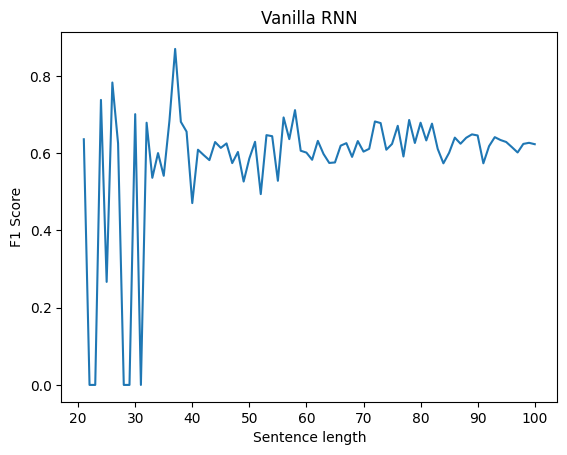

In [22]:
from torcheval.metrics import BinaryF1Score

def get_plot(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    metric = BinaryF1Score()

    metric_per_len = [BinaryF1Score() for i in range(21, MAX_LEN + 1)]
    #print(len(metric_per_len))
    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            metric.update(pred, y)
            #print(pred)
            #print(y)
            #print("\n")
            for i in range(X.shape[0]):
                sent_len = int((X[i].flatten() != 0).sum().item())
                metric_per_len[sent_len - 21].update(pred, y)

            test_loss += loss_fn(pred, y.to(torch.float32)).item()
            correct += (torch.round(pred) == y).type(torch.float).sum().item()
            


    test_loss /= num_batches
    
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, F1-score: {metric.compute()}, Avg loss: {test_loss:>8f} \n")
    
    return metric_per_len

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

metrics = get_plot(test_loader, model, loss_fn)

f1_scores = [metric.compute() for metric in metrics]
f1_scores

plt.plot(range(21, MAX_LEN + 1), f1_scores)
plt.xlabel('Sentence length')
plt.ylabel('F1 Score')
plt.title('Vanilla RNN')
#plt.xticks(range(21, MAX_LEN + 1))

## Parameter sweep

In [12]:
sweep_config = {
    'method': 'random',
}

metric = {
    'name': 'loss',
    'goal': 'minimize'   
    }

sweep_config['metric'] = metric

parameters_dict = {
    'hidden_size': {
        'values': [3, 5, 10, 20]
    },
    'hidden_depth': {
        'values': [1, 2, 3]
    },
    'lr': {
        'values': [1e-2, 1e-3, 1e-4]
    },
    'num_epochs': {
        'values': [100, 200, 300]
    },
}

sweep_config['parameters'] = parameters_dict

import pprint

pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'hidden_depth': {'values': [1, 2, 3]},
                'hidden_size': {'values': [3, 5, 10, 20]},
                'lr': {'values': [0.01, 0.001, 0.0001]},
                'num_epochs': {'values': [100, 200, 300]}}}


In [13]:
import wandb
sweep_id = wandb.sweep(sweep_config, project='rnn-v3')

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: kcjqebdg
Sweep URL: https://wandb.ai/cyrkrytaku/rnn-v3/sweeps/kcjqebdg


In [14]:

def train_wandb(config=None):
    with wandb.init(config=config):
        config = wandb.config
        
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
        val_loader = DataLoader(TextDataset(val_data), batch_size=32, shuffle=False, collate_fn=collate_fn)
        
        model = RNN(embedding_dim, config.hidden_size, config.hidden_depth)
        optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
        criterion = nn.BCELoss()
        

        for epoch in range(config.num_epochs):
            model.train()
            epoch_loss = 0

            for _, (inputs, targets) in enumerate(train_loader):
                #inputs = inputs.unsqueeze(-1)  # Add input_size dimension
                # Forward pass
                outputs = model(inputs)
                #print(outputs)
                loss = criterion(outputs, targets.to(torch.float32))
                
                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
            
            wandb.log({'loss': epoch_loss / len(train_loader)})
            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch + 1}/{config.num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}')
        
        metric = BinaryF1Score()
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets.to(torch.float32))
            wandb.log({'val_loss': loss})
            metric.update(outputs, targets)
            wandb.log({'val_f1': metric.compute()})
            
            

wandb.agent(sweep_id, train, count=5)

In [15]:
wandb.agent(sweep_id, train_wandb, count=10)

wandb: Agent Starting Run: s7m5pszx with config:
wandb: 	hidden_depth: 1
wandb: 	hidden_size: 20
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: magnus-lindberg-christensen (cyrkrytaku). Use `wandb login --relogin` to force relogin


Epoch [10/200], Loss: 0.1777
Epoch [20/200], Loss: 0.1434
Epoch [30/200], Loss: 0.2657
Epoch [40/200], Loss: 0.1599
Epoch [50/200], Loss: 0.1409
Epoch [60/200], Loss: 0.1109
Epoch [70/200], Loss: 0.1554
Epoch [80/200], Loss: 0.1006
Epoch [90/200], Loss: 0.1100
Epoch [100/200], Loss: 0.0924
Epoch [110/200], Loss: 0.1178
Epoch [120/200], Loss: 0.2482
Epoch [130/200], Loss: 0.1260
Epoch [140/200], Loss: 0.2623
Epoch [150/200], Loss: 0.1721
Epoch [160/200], Loss: 0.1543
Epoch [170/200], Loss: 0.2055
Epoch [180/200], Loss: 0.1579
Epoch [190/200], Loss: 0.3265
Epoch [200/200], Loss: 0.3699


loss,██▃▁▁▁▂▄▂▂▂▁▁▂▂▂▂▁▂▁▂▁▃▄▂▂▃▂▇▄▁▃▂▃▁▁▃▁▁▆
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▃▂▃▃▄▆▄▄▁▅▁▆▂▄█▃▄▂▂▃▂▅▄▇▄▄▄▄▇▅█
loss,0.36986
val_f1,0.0
val_loss,0.64317


wandb: Agent Starting Run: pta49hvk with config:
wandb: 	hidden_depth: 3
wandb: 	hidden_size: 3
wandb: 	lr: 0.0001
wandb: 	num_epochs: 300
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch [10/300], Loss: 0.6162
Epoch [20/300], Loss: 0.5629
Epoch [30/300], Loss: 0.5300
Epoch [40/300], Loss: 0.5171
Epoch [50/300], Loss: 0.5087
Epoch [60/300], Loss: 0.5042
Epoch [70/300], Loss: 0.5086
Epoch [80/300], Loss: 0.5038
Epoch [90/300], Loss: 0.5069
Epoch [100/300], Loss: 0.5065
Epoch [110/300], Loss: 0.4985
Epoch [120/300], Loss: 0.4944
Epoch [130/300], Loss: 0.4983
Epoch [140/300], Loss: 0.5022
Epoch [150/300], Loss: 0.4982
Epoch [160/300], Loss: 0.4941
Epoch [170/300], Loss: 0.4940
Epoch [180/300], Loss: 0.4940
Epoch [190/300], Loss: 0.5062
Epoch [200/300], Loss: 0.4980
Epoch [210/300], Loss: 0.5020
Epoch [220/300], Loss: 0.5020
Epoch [230/300], Loss: 0.5099
Epoch [240/300], Loss: 0.5015
Epoch [250/300], Loss: 0.4922
Epoch [260/300], Loss: 0.4302
Epoch [270/300], Loss: 0.3967
Epoch [280/300], Loss: 0.3773
Epoch [290/300], Loss: 0.3634
Epoch [300/300], Loss: 0.3546


loss,█▇▆▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▃▂▂▁▁▁
val_f1,▁▂▂▃▄▆██▆▆▆▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇
val_loss,▃▃▃▄▁▃▃▃▅▂▄▂▅▃▆▆▄▂▄▃▅▁▄▄▅▃▃▄▃▄▄█
loss,0.35456
val_f1,0.93023
val_loss,0.38733


wandb: Agent Starting Run: g63ic4f3 with config:
wandb: 	hidden_depth: 1
wandb: 	hidden_size: 10
wandb: 	lr: 0.0001
wandb: 	num_epochs: 100
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch [10/100], Loss: 0.6277
Epoch [20/100], Loss: 0.5565
Epoch [30/100], Loss: 0.5113
Epoch [40/100], Loss: 0.4929
Epoch [50/100], Loss: 0.4917
Epoch [60/100], Loss: 0.4818
Epoch [70/100], Loss: 0.4122
Epoch [80/100], Loss: 0.3770
Epoch [90/100], Loss: 0.3765
Epoch [100/100], Loss: 0.3756


loss,██▇▇▆▆▆▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▂▂▃▁▄▅▃▄▂▅▁▅▂▅▇▄▂▄▃▃▁▅▄▆▃▃▃▃▆▅█
loss,0.3756
val_f1,0.0
val_loss,0.44309


wandb: Agent Starting Run: lubj3i6l with config:
wandb: 	hidden_depth: 1
wandb: 	hidden_size: 20
wandb: 	lr: 0.01
wandb: 	num_epochs: 300
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch [10/300], Loss: 0.2398
Epoch [20/300], Loss: 0.1536
Epoch [30/300], Loss: 0.1485
Epoch [40/300], Loss: 0.5125
Epoch [50/300], Loss: 0.5029
Epoch [60/300], Loss: 0.4885
Epoch [70/300], Loss: 0.4570
Epoch [80/300], Loss: 0.3847
Epoch [90/300], Loss: 0.4415
Epoch [100/300], Loss: 0.3507
Epoch [110/300], Loss: 0.2495
Epoch [120/300], Loss: 0.1740
Epoch [130/300], Loss: 0.1820
Epoch [140/300], Loss: 0.1495
Epoch [150/300], Loss: 0.2069
Epoch [160/300], Loss: 0.3456
Epoch [170/300], Loss: 0.0861
Epoch [180/300], Loss: 0.0541
Epoch [190/300], Loss: 0.3242
Epoch [200/300], Loss: 0.2092
Epoch [210/300], Loss: 0.1872
Epoch [220/300], Loss: 0.4088
Epoch [230/300], Loss: 0.1374
Epoch [240/300], Loss: 0.0823
Epoch [250/300], Loss: 0.1656
Epoch [260/300], Loss: 0.2796
Epoch [270/300], Loss: 0.3725
Epoch [280/300], Loss: 0.5642
Epoch [290/300], Loss: 0.1910
Epoch [300/300], Loss: 0.4174


loss,▇▃█▂▃███▇▇▆█▆▆▄▄▃▂▂▄▃▅▂▁▁▄▃▃▃▃▃▃▂▅▄▄▄▅▄▇
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▃▂▃▂▄▆▃▄▁▅▁▆▃▃█▃▃▃▄▄▂▅▄▇▃▄▃▃▇▅█
loss,0.41741
val_f1,0.0
val_loss,0.66421


wandb: Agent Starting Run: ygxcaymj with config:
wandb: 	hidden_depth: 2
wandb: 	hidden_size: 5
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch [10/200], Loss: 0.4128
Epoch [20/200], Loss: 0.3382
Epoch [30/200], Loss: 0.3515
Epoch [40/200], Loss: 0.2363
Epoch [50/200], Loss: 0.1948
Epoch [60/200], Loss: 0.2132
Epoch [70/200], Loss: 0.2085
Epoch [80/200], Loss: 0.1927
Epoch [90/200], Loss: 0.3456
Epoch [100/200], Loss: 0.3109
Epoch [110/200], Loss: 0.2316
Epoch [120/200], Loss: 0.2124
Epoch [130/200], Loss: 0.1972
Epoch [140/200], Loss: 0.2132
Epoch [150/200], Loss: 0.3534
Epoch [160/200], Loss: 0.2096
Epoch [170/200], Loss: 0.2078
Epoch [180/200], Loss: 0.1803
Epoch [190/200], Loss: 0.4759
Epoch [200/200], Loss: 0.4828


loss,█▅▆▆▂▂▄▃▁▁▂▁▃▁▁▁▁▃▅▅▂▄▂▂▂▂▂▂▂▆▆▂▂▃▁▁▂▇▇█
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▃▂▂▂▄▆▄▄▁▅▁▅▂▃█▂▃▃▃▃▂▅▃▆▄▄▃▂▇▅█
loss,0.48276
val_f1,0.0
val_loss,0.77942


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x2tsnhyy with config:
wandb: 	hidden_depth: 3
wandb: 	hidden_size: 3
wandb: 	lr: 0.01
wandb: 	num_epochs: 200
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch [10/200], Loss: 0.4987
Epoch [20/200], Loss: 0.4517
Epoch [30/200], Loss: 0.4945
Epoch [40/200], Loss: 0.5093
Epoch [50/200], Loss: 0.4144
Epoch [60/200], Loss: 0.2937
Epoch [70/200], Loss: 0.4063
Epoch [80/200], Loss: 0.2502
Epoch [90/200], Loss: 0.2196
Epoch [100/200], Loss: 0.3642
Epoch [110/200], Loss: 0.3843
Epoch [120/200], Loss: 0.4963
Epoch [130/200], Loss: 0.2070
Epoch [140/200], Loss: 0.1699
Epoch [150/200], Loss: 0.1560
Epoch [160/200], Loss: 0.2013
Epoch [170/200], Loss: 0.1912
Epoch [180/200], Loss: 0.1866
Epoch [190/200], Loss: 0.1804
Epoch [200/200], Loss: 0.1484


loss,████▄▄████▆▆▄▇▆▃▃▃▃▅▄▆▆▃▇▃▂▁▁▁▁▃▂▂▂▂▃▃▂▁
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▇▇▇▆▆▆▆▆▆▅▅
val_loss,▅▄▃▄▃▅▇▅▅▂▅▂▇▄▃█▄▄▄▁▅▄▆▄▇▄▅▅▄▇▅█
loss,0.14839
val_f1,0.04511
val_loss,1.24876


wandb: Agent Starting Run: tu71h6x3 with config:
wandb: 	hidden_depth: 2
wandb: 	hidden_size: 3
wandb: 	lr: 0.0001
wandb: 	num_epochs: 100
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch [10/100], Loss: 0.6136
Epoch [20/100], Loss: 0.5585
Epoch [30/100], Loss: 0.5324
Epoch [40/100], Loss: 0.5215
Epoch [50/100], Loss: 0.5115
Epoch [60/100], Loss: 0.5176
Epoch [70/100], Loss: 0.5053
Epoch [80/100], Loss: 0.5001
Epoch [90/100], Loss: 0.4953
Epoch [100/100], Loss: 0.5058


loss,█▇▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▃▂▃▂▄▆▃▃▁▅▁▆▃▃█▃▃▃▃▃▂▅▃▆▃▄▃▃▇▅█
loss,0.50579
val_f1,0.0
val_loss,0.72932


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 485k5q2c with config:
wandb: 	hidden_depth: 1
wandb: 	hidden_size: 3
wandb: 	lr: 0.0001
wandb: 	num_epochs: 100
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch [10/100], Loss: 0.7083
Epoch [20/100], Loss: 0.6033
Epoch [30/100], Loss: 0.5669
Epoch [40/100], Loss: 0.5451
Epoch [50/100], Loss: 0.5229
Epoch [60/100], Loss: 0.5029
Epoch [70/100], Loss: 0.4871
Epoch [80/100], Loss: 0.4713
Epoch [90/100], Loss: 0.4647
Epoch [100/100], Loss: 0.4283


loss,██▇▇▇▆▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁
val_f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▅▂▂▃▁▄▆▄▅▁▄▁▆▃▂█▃▃▃▂▄▃▄▄▇▄▃▄▂▇▅█
loss,0.42834
val_f1,0.0
val_loss,0.78276


wandb: Agent Starting Run: vh9bby1k with config:
wandb: 	hidden_depth: 2
wandb: 	hidden_size: 20
wandb: 	lr: 0.0001
wandb: 	num_epochs: 100
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch [10/100], Loss: 0.4967
Epoch [20/100], Loss: 0.3178
Epoch [30/100], Loss: 0.2803
Epoch [40/100], Loss: 0.2436
Epoch [50/100], Loss: 0.2219
Epoch [60/100], Loss: 0.1976
Epoch [70/100], Loss: 0.1853
Epoch [80/100], Loss: 0.1982
Epoch [90/100], Loss: 0.1796
Epoch [100/100], Loss: 0.1522


loss,█▇▆▆▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_f1,▁█▃▇▄▇█▄▂▂▄▃▃▃▂▃▃▄▂▃▂▂▂▂▃▃▃▃▃▃▄▄
val_loss,▅▁▃▁▃▃▄█▆▃▂▄▅▅▄▅▄▁█▁▆▄▅▄▅▅▂▅▂▄▄▅
loss,0.15224
val_f1,0.89485
val_loss,0.18376


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n14g815v with config:
wandb: 	hidden_depth: 1
wandb: 	hidden_size: 3
wandb: 	lr: 0.001
wandb: 	num_epochs: 300
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch [10/300], Loss: 0.5070
Epoch [20/300], Loss: 0.4579
Epoch [30/300], Loss: 0.4093
Epoch [40/300], Loss: 0.3900
Epoch [50/300], Loss: 0.2581
Epoch [60/300], Loss: 0.2252
Epoch [70/300], Loss: 0.2095
Epoch [80/300], Loss: 0.2122
Epoch [90/300], Loss: 0.2028
Epoch [100/300], Loss: 0.1979
Epoch [110/300], Loss: 0.2067
Epoch [120/300], Loss: 0.1956
Epoch [130/300], Loss: 0.1874
Epoch [140/300], Loss: 0.1609
Epoch [150/300], Loss: 0.1368
Epoch [160/300], Loss: 0.1330
Epoch [170/300], Loss: 0.1276
Epoch [180/300], Loss: 0.1216
Epoch [190/300], Loss: 0.1189
Epoch [200/300], Loss: 0.1929
Epoch [210/300], Loss: 0.1115
Epoch [220/300], Loss: 0.1112
Epoch [230/300], Loss: 0.1057
Epoch [240/300], Loss: 0.1176
Epoch [250/300], Loss: 0.1005
Epoch [260/300], Loss: 0.1131
Epoch [270/300], Loss: 0.0965
Epoch [280/300], Loss: 0.1349
Epoch [290/300], Loss: 0.0891
Epoch [300/300], Loss: 0.1060


loss,██▇▆▆▆▄▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▃▁▂▁▁▂▁▁▁▁▁▁▂▁
val_f1,█▇▃▁▃▃▄▃▂▂▃▃▂▂▂▃▂▂▂▃▂▂▃▂▂▂▃▃▃▄▄▄
val_loss,▄▂▅▅▁▇▄▆▅▃▄▂▇▄▅▆▇▂▆▁▅▄▂▇█▃▂▄▁▅▂▃
loss,0.106
val_f1,0.90293
val_loss,0.09776
